# Multi-Class Classification Model for [PROJECT NAME] Using Python and Scikit-Learn Version 16
### David Lowe
### December 16, 2021

Template Credit: Adapted from a template made available by Dr. Jason Brownlee of Machine Learning Mastery. [https://machinelearningmastery.com/]

SUMMARY: The project aims to construct a predictive model using various machine learning algorithms and document the end-to-end steps using a template. The [PROJECT NAME] dataset is a multi-class modeling situation where we are trying to predict one of several (more than two) possible outcomes.

INTRODUCTION: [Sample Paragraph - The dataset involves predicting, from USA Forensic Science Service, six types of glass; defined in terms of their oxide content (i.e. Na, Fe, K, etc). The study of classification of types of glass was also partly motivated by criminological investigation. At the scene of the crime, the glass left can be used as evidence…if it is correctly identified!]

ANALYSIS: [Sample Paragraph - The average performance of the machine learning algorithms achieved an accuracy benchmark of 0.6894 using the training dataset. Furthermore, we selected Random Forest as the final model as it processed the training dataset with a final accuracy score of 0.7959. When we processed the test dataset with the final model, the model achieved an accuracy score of 0.8139.]

CONCLUSION: [Sample Paragraph - In this iteration, the Random Forest model appeared to be a suitable algorithm for modeling this dataset.]

Dataset Used: [PROJECT NAME] Dataset

Dataset ML Model: Multi-Class classification with [numerical | categorical] features

Dataset Reference: [https://archive.ics.uci.edu/ml/datasets/glass+identification]

One source of potential performance benchmarks: [https://www.kaggle.com/uciml/glass]

## Task 1 - Prepare Environment

In [1]:
# Retrieve the CPU information
ncpu = !nproc
print("The number of available CPUs is:", ncpu[0])

The number of available CPUs is: 4


### 1.a) Load libraries and modules

In [2]:
# Set the random seed number for reproducible results
RNG_SEED = 888

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys
import math
# import boto3
from datetime import datetime
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn import compose
from sklearn import impute

# from sklearn.feature_selection import RFE
# from imblearn.pipeline import Pipeline
# from imblearn.over_sampling import SMOTE
# from imblearn.under_sampling import RandomUnderSampler

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

### 1.b) Set up the controlling parameters and functions

In [4]:
# Begin the timer for the script processing
START_TIME_SCRIPT = datetime.now()

# Set up the number of CPU cores available for multi-thread processing
N_JOBS = 1

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
NOTIFY_STATUS = False

# Set the percentage sizes for splitting the dataset
TEST_SET_RATIO = 0.2
VAL_SET_RATIO = 0.2

# Set the number of folds for cross validation
N_FOLDS = 5

# Set default modeling scoring metric
SCORING_METRIC = 'accuracy'

In [5]:
# Set up the email notification function
def status_notify(msg_text):
    access_key = os.environ.get('SNS_ACCESS_KEY')
    secret_key = os.environ.get('SNS_SECRET_KEY')
    aws_region = os.environ.get('SNS_AWS_REGION')
    topic_arn = os.environ.get('SNS_TOPIC_ARN')
    if (access_key is None) or (secret_key is None) or (aws_region is None):
        sys.exit("Incomplete notification setup info. Script Processing Aborted!!!")
    sns = boto3.client('sns', aws_access_key_id=access_key, aws_secret_access_key=secret_key, region_name=aws_region)
    response = sns.publish(TopicArn=topic_arn, Message=msg_text)
    if response['ResponseMetadata']['HTTPStatusCode'] != 200 :
        print('Status notification not OK with HTTP status code:', response['ResponseMetadata']['HTTPStatusCode'])

In [6]:
if NOTIFY_STATUS: status_notify("Task 1 - Prepare Environment has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 1.c) Load dataset

In [7]:
dataset_path = 'https://dainesanalytics.com/datasets/example-dataset-for-template/glass_data.txt'
colNames = ['RI','Na','Mg','Al','Si','K','Ca','Ba','Fe','target']
df_dataset_import = pd.read_csv(dataset_path, names=colNames, sep=',', header=None, index_col=0)

# Take a peek at the dataframe after import
print(df_dataset_import.head(10))

         RI     Na    Mg    Al     Si     K    Ca   Ba    Fe  target
1   1.52101  13.64  4.49  1.10  71.78  0.06  8.75  0.0  0.00       1
2   1.51761  13.89  3.60  1.36  72.73  0.48  7.83  0.0  0.00       1
3   1.51618  13.53  3.55  1.54  72.99  0.39  7.78  0.0  0.00       1
4   1.51766  13.21  3.69  1.29  72.61  0.57  8.22  0.0  0.00       1
5   1.51742  13.27  3.62  1.24  73.08  0.55  8.07  0.0  0.00       1
6   1.51596  12.79  3.61  1.62  72.97  0.64  8.07  0.0  0.26       1
7   1.51743  13.30  3.60  1.14  73.09  0.58  8.17  0.0  0.00       1
8   1.51756  13.15  3.61  1.05  73.24  0.57  8.24  0.0  0.00       1
9   1.51918  14.04  3.58  1.37  72.08  0.56  8.30  0.0  0.00       1
10  1.51755  13.00  3.60  1.36  72.99  0.57  8.40  0.0  0.11       1


In [8]:
df_dataset_import.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 214 entries, 1 to 214
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   RI      214 non-null    float64
 1   Na      214 non-null    float64
 2   Mg      214 non-null    float64
 3   Al      214 non-null    float64
 4   Si      214 non-null    float64
 5   K       214 non-null    float64
 6   Ca      214 non-null    float64
 7   Ba      214 non-null    float64
 8   Fe      214 non-null    float64
 9   target  214 non-null    int64  
dtypes: float64(9), int64(1)
memory usage: 18.4 KB


In [9]:
print(df_dataset_import.describe())

               RI          Na          Mg          Al          Si           K  \
count  214.000000  214.000000  214.000000  214.000000  214.000000  214.000000   
mean     1.518365   13.407850    2.684533    1.444907   72.650935    0.497056   
std      0.003037    0.816604    1.442408    0.499270    0.774546    0.652192   
min      1.511150   10.730000    0.000000    0.290000   69.810000    0.000000   
25%      1.516522   12.907500    2.115000    1.190000   72.280000    0.122500   
50%      1.517680   13.300000    3.480000    1.360000   72.790000    0.555000   
75%      1.519157   13.825000    3.600000    1.630000   73.087500    0.610000   
max      1.533930   17.380000    4.490000    3.500000   75.410000    6.210000   

               Ca          Ba          Fe      target  
count  214.000000  214.000000  214.000000  214.000000  
mean     8.956963    0.175047    0.057009    2.780374  
std      1.423153    0.497219    0.097439    2.103739  
min      5.430000    0.000000    0.000000    1

In [10]:
print(df_dataset_import.isnull().sum())
print('Total number of NaN in the dataframe: ', df_dataset_import.isnull().sum().sum())

RI        0
Na        0
Mg        0
Al        0
Si        0
K         0
Ca        0
Ba        0
Fe        0
target    0
dtype: int64
Total number of NaN in the dataframe:  0


### 1.d) Data Cleaning

In [11]:
# Standardize the class column to the name of targetVar if required
# df_dataset_import = df_dataset_import.rename(columns={'old_name': 'targetVar'})

# Dropping features
# df_dataset_import.drop(columns=['column1','column2','column3'], inplace=True)

# Impute missing values
# df_dataset_import['col_name'].fillna('someValue', inplace=True)
# df_dataset_import['col_name'].fillna(value=df_dataset_import['col_name'].median(), inplace=True)

# Convert columns from one data type to another
# df_dataset_import.column_name = df_dataset_import.column_name.astype('int')
# df_dataset_import.column_name = df_dataset_import.column_name.astype('category')

# Convert features with 1/0 levels into categorical feature of Y/N
# def reclass_somecol(code):
#     if code == 1: return 'Y'
#     else: return 'N'
# df_dataset_import['targetVar] = df_dataset_import['targetVar'].apply(reclass_somecol)

# Take a peek at the dataframe after cleaning
print(df_dataset_import.head(10))

         RI     Na    Mg    Al     Si     K    Ca   Ba    Fe  target
1   1.52101  13.64  4.49  1.10  71.78  0.06  8.75  0.0  0.00       1
2   1.51761  13.89  3.60  1.36  72.73  0.48  7.83  0.0  0.00       1
3   1.51618  13.53  3.55  1.54  72.99  0.39  7.78  0.0  0.00       1
4   1.51766  13.21  3.69  1.29  72.61  0.57  8.22  0.0  0.00       1
5   1.51742  13.27  3.62  1.24  73.08  0.55  8.07  0.0  0.00       1
6   1.51596  12.79  3.61  1.62  72.97  0.64  8.07  0.0  0.26       1
7   1.51743  13.30  3.60  1.14  73.09  0.58  8.17  0.0  0.00       1
8   1.51756  13.15  3.61  1.05  73.24  0.57  8.24  0.0  0.00       1
9   1.51918  14.04  3.58  1.37  72.08  0.56  8.30  0.0  0.00       1
10  1.51755  13.00  3.60  1.36  72.99  0.57  8.40  0.0  0.11       1


In [12]:
df_dataset_import.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 214 entries, 1 to 214
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   RI      214 non-null    float64
 1   Na      214 non-null    float64
 2   Mg      214 non-null    float64
 3   Al      214 non-null    float64
 4   Si      214 non-null    float64
 5   K       214 non-null    float64
 6   Ca      214 non-null    float64
 7   Ba      214 non-null    float64
 8   Fe      214 non-null    float64
 9   target  214 non-null    int64  
dtypes: float64(9), int64(1)
memory usage: 18.4 KB


In [13]:
print(df_dataset_import.describe())

               RI          Na          Mg          Al          Si           K  \
count  214.000000  214.000000  214.000000  214.000000  214.000000  214.000000   
mean     1.518365   13.407850    2.684533    1.444907   72.650935    0.497056   
std      0.003037    0.816604    1.442408    0.499270    0.774546    0.652192   
min      1.511150   10.730000    0.000000    0.290000   69.810000    0.000000   
25%      1.516522   12.907500    2.115000    1.190000   72.280000    0.122500   
50%      1.517680   13.300000    3.480000    1.360000   72.790000    0.555000   
75%      1.519157   13.825000    3.600000    1.630000   73.087500    0.610000   
max      1.533930   17.380000    4.490000    3.500000   75.410000    6.210000   

               Ca          Ba          Fe      target  
count  214.000000  214.000000  214.000000  214.000000  
mean     8.956963    0.175047    0.057009    2.780374  
std      1.423153    0.497219    0.097439    2.103739  
min      5.430000    0.000000    0.000000    1

In [14]:
print(df_dataset_import.isnull().sum())
print('Total number of NaN in the dataframe: ', df_dataset_import.isnull().sum().sum())

RI        0
Na        0
Mg        0
Al        0
Si        0
K         0
Ca        0
Ba        0
Fe        0
target    0
dtype: int64
Total number of NaN in the dataframe:  0


### 1.e) Splitting Data into Sets

In [15]:
# Use variable total_column_count to hold the number of columns in the dataframe
total_column_count = len(df_dataset_import.columns)

# Set up variable total_feature_count for the total number of attribute columns
total_feature_count = total_column_count-1

# We create attribute-only and target-only datasets (df_features_train and df_target_train)
df_target_import = df_dataset_import['target']
df_features_import = df_dataset_import.drop(['target'], axis=1)

print("df_dataset_import.shape: {} df_features_import.shape: {} df_target_import.shape: {}".format(df_dataset_import.shape, df_features_import.shape, df_target_import.shape))

df_dataset_import.shape: (214, 10) df_features_import.shape: (214, 9) df_target_import.shape: (214,)


In [16]:
# Split the data further into training and test datasets
df_features_train, df_features_test, df_target_train, df_target_test = train_test_split(df_features_import, df_target_import,
                                                                                        test_size=TEST_SET_RATIO, random_state=RNG_SEED)
print("df_features_train.shape: {} df_target_train.shape: {}".format(df_features_train.shape, df_target_train.shape))
print("df_features_test.shape: {} df_target_test.shape: {}".format(df_features_test.shape, df_target_test.shape))

df_features_train.shape: (171, 9) df_target_train.shape: (171,)
df_features_test.shape: (43, 9) df_target_test.shape: (43,)


### 1.f) Set up the parameters for data visualization

In [17]:
# Set up the number of row and columns for visualization display. display_rows * display_columns should be >= total_feature_count
display_columns = 4
if total_feature_count % display_columns == 0 :
    display_rows = total_feature_count // display_columns
else :
    display_rows = (total_feature_count // display_columns) + 1

# Set figure width to display the data visualization plots
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = display_columns * 4
fig_size[1] = display_rows * 4
plt.rcParams["figure.figsize"] = fig_size

In [18]:
if NOTIFY_STATUS: status_notify("Task 1 - Prepare Environment completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 2 - Summarize and Visualize Data

In [19]:
if NOTIFY_STATUS: status_notify("Task 2 - Summarize and Visualize Data has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

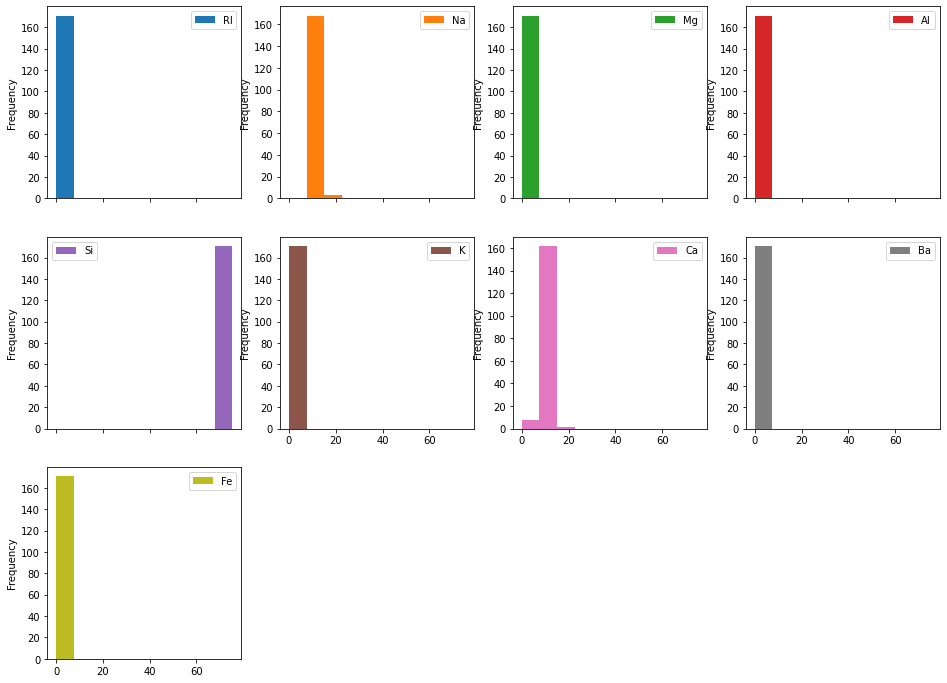

In [20]:
# Histograms for each attribute
df_features_train.plot(kind='hist', subplots=True, layout=(display_rows, display_columns))
plt.show()

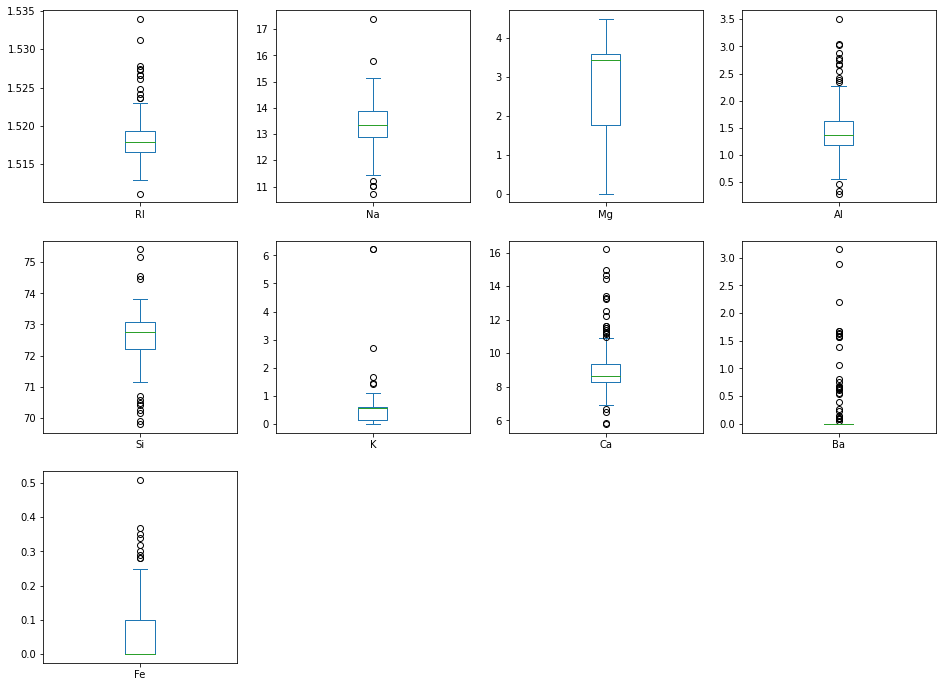

In [21]:
# Box and Whisker plot for each attribute
df_features_train.plot(kind='box', subplots=True, layout=(display_rows, display_columns))
plt.show()

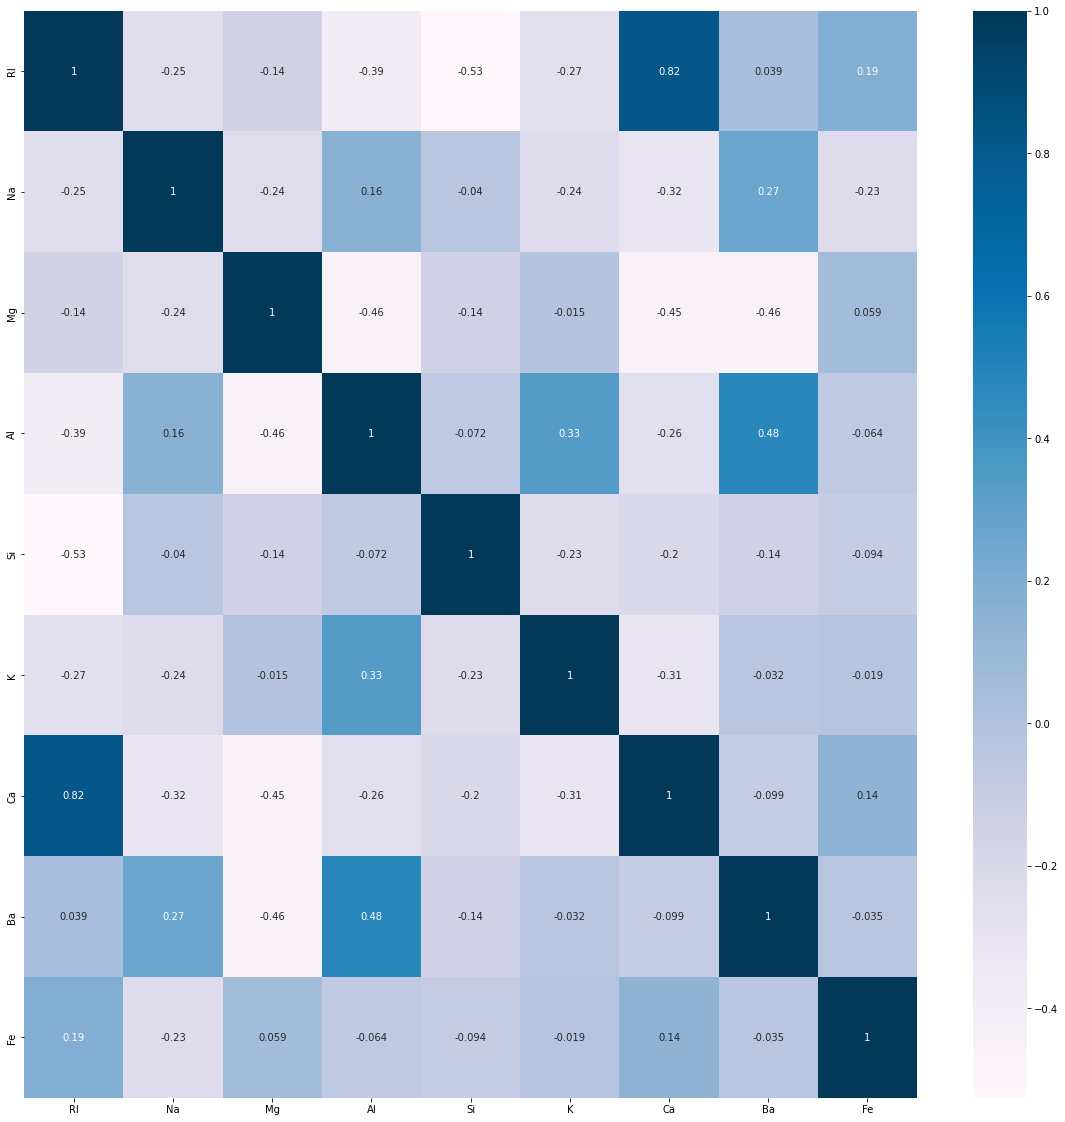

In [22]:
# Correlation matrix
fig = plt.figure(figsize=(20, 20))
correlations = df_features_train.corr(method='pearson')
sns.heatmap(correlations, annot=True, cmap=plt.cm.PuBu)
plt.show()

In [23]:
if NOTIFY_STATUS: status_notify("Task 2 - Summarize and Visualize Data completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 3 - Pre-process Data

In [24]:
if NOTIFY_STATUS: status_notify("Task 3 - Pre-process Data has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 3.a) Feature Scaling and Data Pre-Processing

In [25]:
# Compose pipeline for the numerical and categorical features (Block #1 of 2)
numeric_columns = df_features_train.select_dtypes(include=['int64','float64']).columns
numeric_transformer = Pipeline(steps=[
    ('imputer', impute.SimpleImputer(strategy="constant", fill_value=0)),
    ('scaler', preprocessing.MinMaxScaler())
])
categorical_columns = df_features_train.select_dtypes(include=['object','bool','category']).columns
categorical_transformer = Pipeline(steps=[
    ('imputer', impute.SimpleImputer(strategy='constant', fill_value='UKNOWN')),
    ('onehot', preprocessing.OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

print("Number of numerical columns:", len(numeric_columns))
print("Number of categorical columns:", len(categorical_columns))
print("Total number of columns in the feature dataframe:", df_features_train.shape[1])

Number of numerical columns: 9
Number of categorical columns: 0
Total number of columns in the feature dataframe: 9


In [26]:
# Compose pipeline for the numerical and categorical features (Block #2 of 2)
preprocessor = compose.ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_columns),
    ('cat', categorical_transformer, categorical_columns)
])

# Display the shapes of the training dataset for final inspection
array_features_train = preprocessor.fit_transform(df_features_train)
print("Transformed features from df_features_train.shape: {} to array_features_train.shape: {}".format(df_features_train.shape, array_features_train.shape))

Transformed features from df_features_train.shape: (171, 9) to array_features_train.shape: (171, 9)


### 3.b) Training Data Balancing

In [27]:
# Not applicable for this iteration of the project

In [28]:
# Perform SMOTE transformation on the training data (Block #1 of 2)

# X_train_imbal = X_train_df.values
# y_train_imbal = y_train_df.values.ravel()
# print("X_train_imbal.shape: {} y_train_imbal.shape: {}".format(X_train_imbal.shape, y_train_imbal.shape))

In [29]:
# Perform SMOTE transformation on the training data (Block #2 of 2)

# print ('Original class distribution - 1: {} | 0: {}'.format((y_train_imbal==1).sum(), (y_train_imbal==0).sum()))
# sm = SMOTE(random_state=RNG_SEED, sampling_strategy=1.0)
# X_trainSmote, y_trainSmote = sm.fit_sample(X_train_imbal, y_train_imbal)
# print ('Resampled class distribution - 1: {} | 0: {}'.format((y_train==1).sum(), (y_train==0).sum()))

### 3.c) Feature Selection

In [30]:
# Not applicable for this iteration of the project

In [31]:
# Find collinear features (Block #1 of 3)

# def findCorrelated(corrmat, cutoff = 0.75):    

# ### search correlation matrix and identify pairs that if removed would reduce pair-wise correlations
# # args:
#     # corrmat: a correlation matrix
#     # cutoff: pairwise absolute correlation cutoff
# # returns:
#     # variables to removed

#     if(len(corrmat) != len(corrmat.columns)) : return 'Correlation matrix is not square'
#     averageCorr = corrmat.abs().mean(axis = 1)

#     # set lower triangle and diagonal of correlation matrix to NA
#     for row in range(0, len(corrmat)):
#         for col in range(0, (row+1)):
#             corrmat.iloc[row, col] = None

#     # where a pairwise correlation is greater than the cutoff value, check whether mean abs.corr of a or b is greater and cut it
#     to_delete = list()
#     for col in range(0, len(corrmat.columns)):
#         for row in range(0, len(corrmat)):
#             if(abs(corrmat.iloc[row, col]) > cutoff):
#                 if(averageCorr.iloc[row] > averageCorr.iloc[col]): to_delete.append(row)
#                 else: to_delete.append(col)

#     to_delete = list(set(to_delete))
#     return to_delete

In [32]:
# Find collinear features (Block #2 of 3)

# By using the calculated correlation matrix, find the collinear features
# collinear = findCorrelated(correlations, cutoff = 0.75)
# print('Number of attributes to be removed:', len(collinear))
# dropAttributes = X_train_df.columns[collinear]
# print('Columns to be removed:')
# print(dropAttributes)

In [33]:
# Find collinear features (Block #3 of 3)

# Drop the highly collinear features
# X_train_df.drop(labels=dropAttributes, axis=1, inplace=True)
# X_test_df.drop(labels=dropAttributes, axis=1, inplace=True)

In [34]:
# Perform Attribute Importance Ranking (Block #1 of 3)

# Feature Importance with Gradient Boosting Classifier
# X_impVal = X_train_df.values
# y_impVal = y_train_df.values.ravel()
# model = GradientBoostingClassifier(random_state=RNG_SEED)
# model.fit(X_impVal, y_impVal)
# importanceScore = model.feature_importances_
# attributeList = X_train_df.columns.tolist()
# attributeImportance = pd.DataFrame({'attribute': attributeList, 'importance': importanceScore})
# rankedAttributes = attributeImportance.sort_values('importance', ascending=False)
# print(rankedAttributes)

In [35]:
# Perform Attribute Importance Ranking (Block #2 of 3)

# Set the importance threshold and calculate the list of attributes that don't contribute to the importance threshold
# importanceSum = sum(importanceScore)
# maxThreshold = 0.99
# i = 0
# accumWeight = 0
# exit_now = False
# while ((i < totAttr) and (not exit_now)) :
#     accumWeight = accumWeight + (rankedAttributes.iloc[i]['importance']/importanceSum)
#     if (accumWeight >= maxThreshold) :
#         exit_now = True
#     else :
#         i = i + 1
# print('Number of attributes contributed to the importance threshold:'+str(i))
# lowAttributes = rankedAttributes.iloc[(i):(totAttr),]['attribute'].tolist()
# print('Number of attributes found to be of low importance:',len(lowAttributes))
# print(lowAttributes)

In [36]:
# Perform Attribute Importance Ranking (Block #3 of 3)

# Removing the unselected attributes from the training and validation dataframes
# X_train_df.drop(labels=lowAttributes, axis=1, inplace=True)
# X_test_df.drop(labels=lowAttributes, axis=1, inplace=True)

In [37]:
# Perform Recursive Feature Elimination (Block #1 of 3)

# Using the ensemlbed tree algorithm, we perform the Recursive Feature Elimination (RFE) technique
# X_rfeVal = X_train_df.values
# y_rfeVal = y_train_df.values.ravel()
# estFunc = ExtraTreesClassifier(random_state=RNG_SEED, n_jobs=cpu_num)
# strFold = StratifiedKFold(n_splits=num_folds, random_state=RNG_SEED)
# minFeatures = 10
# selector = RFECV(estimator=estFunc, step=1, min_features_to_select= minFeatures, cv=strFold, scoring=scoring)
# selector = selector.fit(X_rfeVal, y_rfeVal)
# print('The number of selected features:',selector.n_features_)
# print('The mask of selected features:\n',selector.support_)
# print('The ranking of selected features:\n',selector.ranking_)
# plt.figure(figsize=(16,12))
# plt.xlabel("Number of features selected")
# plt.ylabel("Cross validation score")
# plt.plot(range(minFeatures, len(selector.grid_scores_) + minFeatures), selector.grid_scores_)
# plt.show()

In [38]:
# Perform Recursive Feature Elimination (Block #2 of 3)

# Remove the unselected attributes from the training dataframes
# X_train_df = X_train_df[X_train_df.columns[selector.support_]]
# print(X_train_df.shape)
# X_train_df.head()

In [39]:
# Perform Recursive Feature Elimination (Block #3 of 3)

# Remove the unselected attributes from the validation dataframes
# X_test_df = X_test_df[X_test_df.columns[selector.support_]]
# print(X_test_df.shape)
# X_test_df.head()

### 3.d) Display the Final Datasets for Model-Building

In [40]:
# Finalize the training dataset for the modeling activities
# array_features_train = df_features_train.to_numpy()
array_target_train = df_target_train.ravel()
print("array_features_train.shape: {} array_target_train.shape: {}".format(array_features_train.shape, array_target_train.shape))

array_features_train.shape: (171, 9) array_target_train.shape: (171,)


In [41]:
if NOTIFY_STATUS: status_notify("Task 3 - Pre-process Data completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 4 - Train and Tune Models

In [42]:
if NOTIFY_STATUS: status_notify("Task 4 - Train and Tune Models has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 4.a) Set test options and evaluation metric

In [43]:
# Set up Algorithms Spot-Checking Array
start_time_training = datetime.now()
train_models = []
train_results = []
train_model_names = []
train_metrics = []

In [44]:
train_models.append(('LDA', LinearDiscriminantAnalysis()))
train_models.append(('CART', DecisionTreeClassifier(random_state=RNG_SEED)))
train_models.append(('KNN', KNeighborsClassifier(n_jobs=N_JOBS)))
train_models.append(('BGT', BaggingClassifier(random_state=RNG_SEED, n_jobs=N_JOBS)))
train_models.append(('RNF', RandomForestClassifier(random_state=RNG_SEED, n_jobs=N_JOBS)))
train_models.append(('EXT', ExtraTreesClassifier(random_state=RNG_SEED, n_jobs=N_JOBS)))

In [45]:
# Generate model in turn
for name, model in train_models:
	if NOTIFY_STATUS: status_notify("Algorithm", name, "modeling has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
	start_time_module = datetime.now()
	kfold = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RNG_SEED)
	cv_results = cross_val_score(model, array_features_train, array_target_train, cv=kfold, scoring=SCORING_METRIC, n_jobs=N_JOBS, verbose=1)
	train_results.append(cv_results)
	train_model_names.append(name)
	train_metrics.append(cv_results.mean())
	print("%s: %f (%f)" % (name, cv_results.mean(), cv_results.std()))
	print(model)
	print ('Model training time:', (datetime.now() - start_time_module), '\n')
	if NOTIFY_STATUS: status_notify("Algorithm", name, "modeling completed!", datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
print ('Average metrics (' + SCORING_METRIC + ') from all models:', np.mean(train_metrics))
print ('Total training time for all models:', (datetime.now() - start_time_training))

LDA: 0.614622 (0.082455)
LinearDiscriminantAnalysis()
Model training time: 0:00:00.030860 

CART: 0.614790 (0.076780)
DecisionTreeClassifier(random_state=888)
Model training time: 0:00:00.028797 

KNN: 0.625546 (0.057998)
KNeighborsClassifier(n_jobs=1)
Model training time: 0:00:00.041013 



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


BGT: 0.719496 (0.070095)
BaggingClassifier(n_jobs=1, random_state=888)
Model training time: 0:00:00.329206 



[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


RNF: 0.795966 (0.078441)
RandomForestClassifier(n_jobs=1, random_state=888)
Model training time: 0:00:02.399152 

EXT: 0.766555 (0.069841)
ExtraTreesClassifier(n_jobs=1, random_state=888)
Model training time: 0:00:01.768384 

Average metrics (accuracy) from all models: 0.6894957983193278
Total training time for all models: 0:00:04.639747


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.8s finished


### 4.b) Spot-checking baseline algorithms

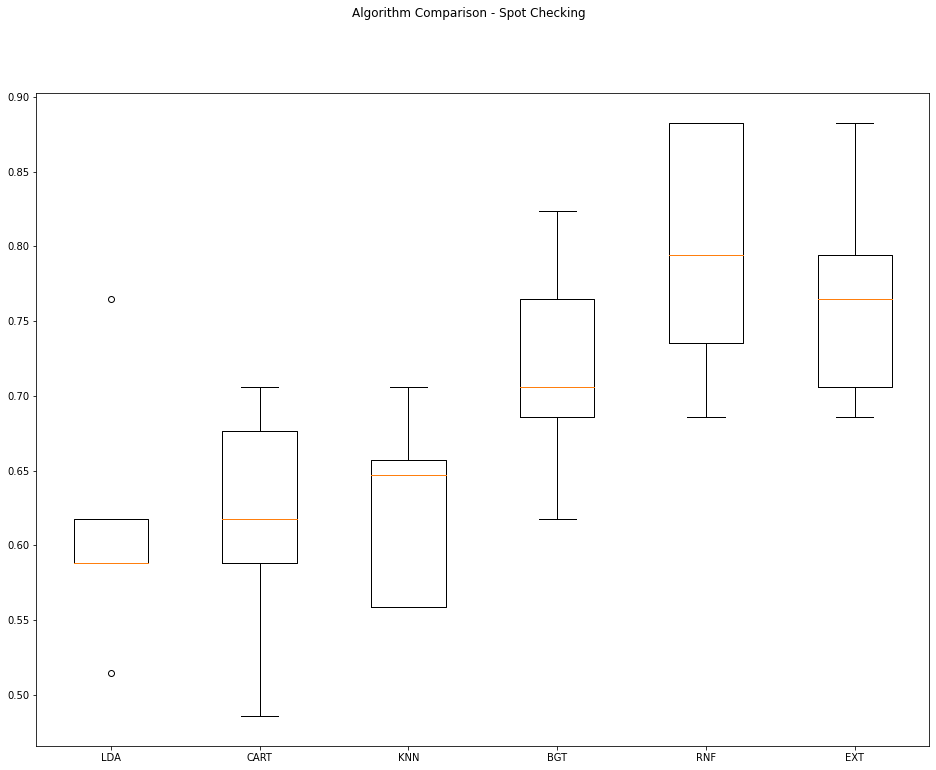

In [46]:
fig = plt.figure(figsize=(16,12))
fig.suptitle('Algorithm Comparison - Spot Checking')
ax = fig.add_subplot(111)
plt.boxplot(train_results)
ax.set_xticklabels(train_model_names)
plt.show()

In [47]:
if NOTIFY_STATUS: status_notify("Task 4 - Train and Tune Models completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 4.c) Algorithm Tuning

In [48]:
# Set up the comparison array
tune_results = []
tune_model_names = []

In [49]:
# Tuning algorithm #1
start_time_module = datetime.now()
if NOTIFY_STATUS: status_notify("Algorithm #1 tuning has begun!", datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

tune_model1 = ExtraTreesClassifier(random_state=RNG_SEED, n_jobs=N_JOBS)
tune_model_names.append('EXT')
paramGrid1 = dict(n_estimators=np.array([100, 300, 500]))

kfold = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RNG_SEED)
grid1 = GridSearchCV(estimator=tune_model1, param_grid=paramGrid1, scoring=SCORING_METRIC, cv=kfold, n_jobs=N_JOBS, verbose=1)
grid_result1 = grid1.fit(array_features_train, array_target_train)

print("Best: %f using %s" % (grid_result1.best_score_, grid_result1.best_params_))
tune_results.append(grid_result1.cv_results_['mean_test_score'])
means = grid_result1.cv_results_['mean_test_score']
stds = grid_result1.cv_results_['std_test_score']
params = grid_result1.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print ('Model training time:', (datetime.now() - start_time_module))
if NOTIFY_STATUS: status_notify("Algorithm #1 tuning completed!", datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best: 0.777983 using {'n_estimators': 500}
0.766555 (0.069841) with: {'n_estimators': 100}
0.766218 (0.048398) with: {'n_estimators': 300}
0.777983 (0.070260) with: {'n_estimators': 500}
Model training time: 0:00:17.111404


In [50]:
best_paramKey1 = list(grid_result1.best_params_.keys())[0]
best_paramValue1 = list(grid_result1.best_params_.values())[0]
print("Captured the best parameter for algorithm #1:", best_paramKey1, '=', best_paramValue1)

Captured the best parameter for algorithm #1: n_estimators = 500


In [51]:
# Tuning algorithm #2
start_time_module = datetime.now()
if NOTIFY_STATUS: status_notify("Algorithm #2 tuning has begun!", datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

tune_model2 = RandomForestClassifier(random_state=RNG_SEED, n_jobs=N_JOBS)
tune_model_names.append('RNF')
paramGrid2 = dict(n_estimators=np.array([100, 300, 500]))

kfold = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RNG_SEED)
grid2 = GridSearchCV(estimator=tune_model2, param_grid=paramGrid2, scoring=SCORING_METRIC, cv=kfold, n_jobs=N_JOBS, verbose=1)
grid_result2 = grid2.fit(array_features_train, array_target_train)

print("Best: %f using %s" % (grid_result2.best_score_, grid_result2.best_params_))
tune_results.append(grid_result2.cv_results_['mean_test_score'])
means = grid_result2.cv_results_['mean_test_score']
stds = grid_result2.cv_results_['std_test_score']
params = grid_result2.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print ('Model training time:', (datetime.now() - start_time_module))
if NOTIFY_STATUS: status_notify("Algorithm #2 tuning completed!", datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best: 0.795966 using {'n_estimators': 100}
0.795966 (0.078441) with: {'n_estimators': 100}
0.790084 (0.081604) with: {'n_estimators': 300}
0.795798 (0.074814) with: {'n_estimators': 500}
Model training time: 0:00:22.163518


In [52]:
best_paramKey2 = list(grid_result2.best_params_.keys())[0]
best_paramValue2 = list(grid_result2.best_params_.values())[0]
print("Captured the best parameter for algorithm #2:", best_paramKey2, '=', best_paramValue2)

Captured the best parameter for algorithm #2: n_estimators = 100


### 4.d) Compare Algorithms After Tuning

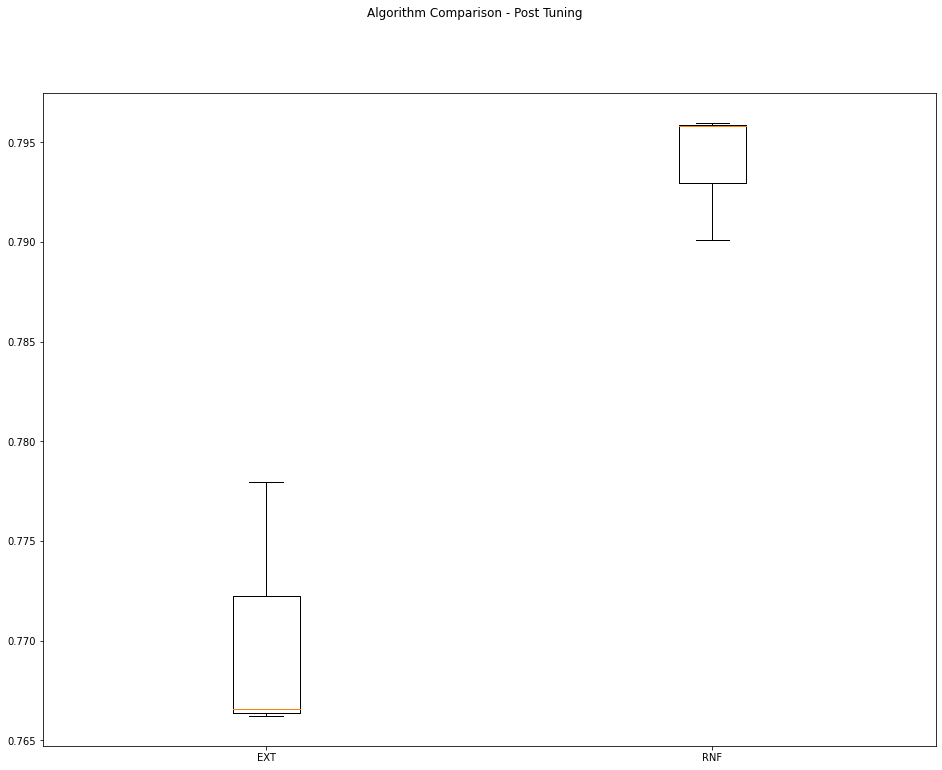

In [53]:
fig = plt.figure(figsize=(16,12))
fig.suptitle('Algorithm Comparison - Post Tuning')
ax = fig.add_subplot(111)
plt.boxplot(tune_results)
ax.set_xticklabels(tune_model_names)
plt.show()

In [54]:
if NOTIFY_STATUS: status_notify("Task 4 - Train and Tune Models completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 5 - Finalize Model and Make Predictions

In [55]:
if NOTIFY_STATUS: status_notify("Task 5 - Finalize Model and Make Predictions has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 5.a) Train the Final Model

In [56]:
final_model = RandomForestClassifier(n_estimators=best_paramValue2, random_state=RNG_SEED, n_jobs=N_JOBS)
final_model.fit(array_features_train, array_target_train)
print(final_model)

RandomForestClassifier(n_jobs=1, random_state=888)


### 5.b) Load Test Dataset and Make Predictions

In [57]:
# Finalize the test dataset for the testing activities
array_features_test = preprocessor.transform(df_features_test)
array_target_test = df_target_test.ravel()
print("array_features_test.shape: {} array_target_test.shape: {}".format(array_features_test.shape, array_target_test.shape))

array_features_test.shape: (43, 9) array_target_test.shape: (43,)


In [58]:
# Make batched predictions
test_predictions = final_model.predict(array_features_test)
print(test_predictions)

[2 3 3 2 1 1 2 7 1 2 2 1 1 2 2 2 2 5 1 1 7 3 1 1 2 2 1 1 7 2 1 2 1 2 2 3 2
 1 7 5 2 2 2]


In [59]:
print('Accuracy Score:', accuracy_score(array_target_test, test_predictions), '\n')
print(confusion_matrix(array_target_test, test_predictions), '\n')
print(classification_report(array_target_test, test_predictions))

Accuracy Score: 0.813953488372093 

[[12  3  2  0  0  0]
 [ 0 15  0  0  0  0]
 [ 0  0  2  0  0  0]
 [ 0  0  0  2  0  0]
 [ 1  0  0  0  0  0]
 [ 1  1  0  0  0  4]] 

              precision    recall  f1-score   support

           1       0.86      0.71      0.77        17
           2       0.79      1.00      0.88        15
           3       0.50      1.00      0.67         2
           5       1.00      1.00      1.00         2
           6       0.00      0.00      0.00         1
           7       1.00      0.67      0.80         6

    accuracy                           0.81        43
   macro avg       0.69      0.73      0.69        43
weighted avg       0.82      0.81      0.80        43



/home/pythonml/appdev/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/pythonml/appdev/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/pythonml/appdev/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [60]:
if NOTIFY_STATUS: status_notify("Task 5 - Finalize Model and Make Predictions completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [61]:
print ('Total time for the script:',(datetime.now() - START_TIME_SCRIPT))

Total time for the script: 0:00:54.052525
